In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from codecarbon import EmissionsTracker
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
df = pd.read_csv("/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/dataset.csv")
df

,Class,Raw Count,Augmented Count
0,Glioma,400,1500
1,Meningioma,400,1500
2,Pituitary,400,1500
3,No Tumor,400,1500


In [4]:

DATASET_A_TRAIN = '/kaggle/input/brain-tumor-dataset/Training'
DATASET_A_TEST = '/kaggle/input/brain-tumor-dataset/Testing' 


DATASET_B_TRAIN = '/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data/Augmented'


MERGED_TRAIN_DIR = '/kaggle/working/merged_brain_tumor_training'


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25 
MODEL_SAVE_PATH = "/kaggle/working/"

In [9]:
def merge_datasets(source_dirs_with_mappings, target_dir):

    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    
    print(f"Creating new directory at: {target_dir}")
    
    
    standard_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for cls in standard_classes:
        os.makedirs(os.path.join(target_dir, cls))
        
    
    for source_dir, mapping in source_dirs_with_mappings:
        print(f"\nCopying files from: {source_dir}")
        for source_class, target_class in mapping.items():
            source_path = os.path.join(source_dir, source_class)
            target_path = os.path.join(target_dir, target_class)
            
            if not os.path.exists(source_path):
                print(f"  - Warning: Source directory not found, skipping: {source_path}")
                continue

            files = os.listdir(source_path)
            for file in files:
                shutil.copy(os.path.join(source_path, file), target_path)
            print(f"  - Copied {len(files)} files from '{source_class}' to '{target_class}'")


mapping_A = {
    'glioma': 'glioma',
    'meningioma': 'meningioma',
    'notumor': 'notumor',
    'pituitary': 'pituitary'
}


mapping_B = {
    '512Glioma': 'glioma',
    '512Meningioma': 'meningioma',
    '512Normal': 'notumor',
    '512Pituitary': 'pituitary'
}


sources = [
    (DATASET_A_TRAIN, mapping_A),
    (DATASET_B_TRAIN, mapping_B)
]


merge_datasets(sources, MERGED_TRAIN_DIR)

Creating new directory at: /kaggle/working/merged_brain_tumor_training

Copying files from: /kaggle/input/brain-tumor-dataset/Training
  - Copied 1321 files from 'glioma' to 'glioma'
  - Copied 1339 files from 'meningioma' to 'meningioma'
  - Copied 1595 files from 'notumor' to 'notumor'
  - Copied 1457 files from 'pituitary' to 'pituitary'

Copying files from: /kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data/Augmented
  - Copied 1501 files from '512Glioma' to 'glioma'
  - Copied 1501 files from '512Meningioma' to 'meningioma'
  - Copied 1501 files from '512Normal' to 'notumor'
  - Copied 1501 files from '512Pituitary' to 'pituitary'


In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory


VALIDATION_SPLIT = 0.2 

print("--- Loading and Splitting Datasets using the recommended 'validation_split' method ---")


train_ds = image_dataset_from_directory(
    directory=MERGED_TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='training' 
)


val_ds = image_dataset_from_directory(
    directory=MERGED_TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation' 
)


test_ds = image_dataset_from_directory(
    directory=DATASET_A_TEST,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False 
)


class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nSuccessfully loaded datasets. Found {num_classes} classes: {class_names}")


AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Number of batches -> Train: {len(train_ds)}, Validation: {len(val_ds)}, Test: {len(test_ds)}")

--- Loading and Splitting Datasets using the recommended 'validation_split' method ---
Found 11716 files belonging to 4 classes.
Using 9373 files for training.
Found 11716 files belonging to 4 classes.
Using 2343 files for validation.
Found 1311 files belonging to 4 classes.

Successfully loaded datasets. Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of batches -> Train: 293, Validation: 74, Test: 41


In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=30

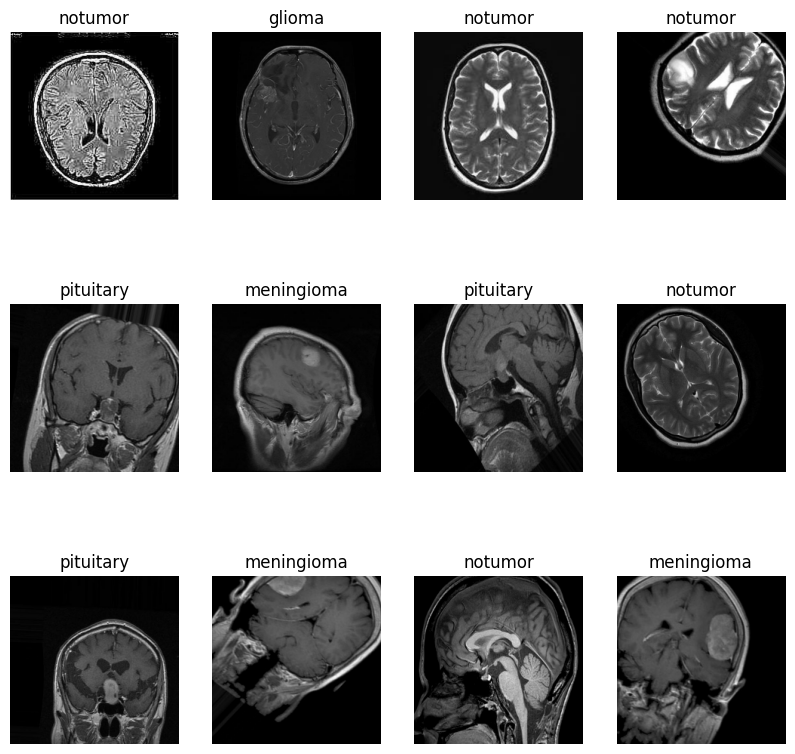

In [19]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [22]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.02, fill_mode='constant'),
    tf.keras.layers.RandomContrast(factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.01, width_factor=0.05),
    tf.keras.layers.RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant')
], name="data_augmentation")

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
len(train_ds)

293

In [25]:
import os
from collections import Counter

# Dataset directory
dataset_dir = '/kaggle/working/merged_brain_tumor_training'

#  Collect all file paths per class
all_filepaths = []
all_labels = []

for label in sorted(os.listdir(dataset_dir)):
    class_dir = os.path.join(dataset_dir, label)
    for fname in os.listdir(class_dir):
        all_filepaths.append(os.path.join(class_dir, fname))
        all_labels.append(label)

#  Split manually (train, val, test)
from sklearn.model_selection import train_test_split

train_filepaths, temp_filepaths, train_labels, temp_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

val_filepaths, test_filepaths, val_labels, test_labels = train_test_split(
    temp_filepaths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

#  Check duplicates in validation
val_fnames = [os.path.basename(f) for f in val_filepaths]
val_counter = Counter(val_fnames)
duplicates = [f for f, c in val_counter.items() if c > 1]
print(f"Duplicate files in validation set: {len(duplicates)}")
if duplicates:
    print("Duplicates:", duplicates)

#  Check overlap between train & val
train_fnames = [os.path.basename(f) for f in train_filepaths]
overlap = set(train_fnames) & set(val_fnames)
print(f"Number of overlapping files between train & validation: {len(overlap)}")
if overlap:
    print("Overlapping files:", overlap)


Duplicate files in validation set: 0
Number of overlapping files between train & validation: 0


In [26]:
def get_callbacks(model_name):
    return [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{model_name}_best.h5", monitor="val_loss", save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6),
        CSVLogger(f"{model_name}_training_log.csv", append=True)
    ]

In [27]:
from codecarbon import EmissionsTracker
import time

def train_all_models(models_dict, train_ds, val_ds, BATCH_SIZE, EPOCHS):
    histories = {}

    for name, model in models_dict.items():
        print(f"\n Training {name}...")

        
        tracker = EmissionsTracker(
            project_name=name,
            output_dir=".",
            save_to_file=True,
            log_level="error"
        )
        tracker.start()

        
        start_time = time.time()

        
        history = model.fit(
            train_ds,
            batch_size=BATCH_SIZE,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=get_callbacks(name),
            verbose=1
        )

        
        end_time = time.time()
        duration = end_time - start_time
        print(f" Training time for {name}: {duration/60:.2f} minutes")

        
        emissions = tracker.stop()
        print(f" Carbon emissions for {name}: {emissions:.4f} kg CO2eq")

        
        histories[name] = {
            "history": history,
            "training_time": duration,
            "emissions": emissions
        }

    return histories


In [28]:
def build_transfer_model(base_model_fn):
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
models_dict = {
    "ResNet50": build_transfer_model(applications.ResNet50),
    "EfficientNetV2B3": build_transfer_model(applications.EfficientNetV2B3),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2),
    
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
histories = train_all_models(models_dict, train_ds, val_ds, BATCH_SIZE, EPOCHS)

print("\n--- All models trained successfully! ---")
for model_name, data in histories.items():
    print(f"\nResults for {model_name}:")
    print(f"  Training time: {data['training_time']/60:.2f} minutes")
    print(f"  Emissions: {data['emissions']:.4f} kg CO2eq")

[codecarbon WARNING @ 19:15:43] Multiple instances of codecarbon are allowed to run at the same time.



 Training ResNet50...
Epoch 1/30


I0000 00:00:1758050168.415469     117 service.cc:148] XLA service 0x7d857404ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758050168.416225     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758050168.416250     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758050169.895211     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/293 ━━━━━━━━━━━━━━━━━━━━ 2:21:52 29s/step - accuracy: 0.2188 - loss: 3.0933

I0000 00:00:1758050176.719020     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


293/293 ━━━━━━━━━━━━━━━━━━━━ 174s 497ms/step - accuracy: 0.6772 - loss: 0.8694 - val_accuracy: 0.8715 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 133s 453ms/step - accuracy: 0.8410 - loss: 0.4149 - val_accuracy: 0.8638 - val_loss: 0.3431 - learning_rate: 0.0010
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 134s 458ms/step - accuracy: 0.8773 - loss: 0.3267 - val_accuracy: 0.9040 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 134s 458ms/step - accuracy: 0.8704 - loss: 0.3172 - val_accuracy: 0.8498 - val_loss: 0.3992 - learning_rate: 0.0010
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 134s 458ms/step - accuracy: 0.8972 - loss: 0.2659 - val_accuracy: 0.8835 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 132s 450ms/step - accuracy: 0.9004 - loss: 0.2638 - val_accuracy: 0.8685 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 133s 455ms/step - accuracy: 0.9203 

In [33]:
import numpy as np
from sklearn.metrics import classification_report

y_true = np.concatenate([labels for images, labels in test_ds], axis=0)

for name, model in models_dict.items():
    print(f"\n{'='*30}\nClassification Report for {name}\n{'='*30}")
    
    predictions = model.predict(test_ds)
    
    y_pred = np.argmax(predictions, axis=1)
    
    print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report for ResNet50
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step
              precision    recall  f1-score   support

      giloma       0.97      0.76      0.85       300
  meningioma       0.76      0.76      0.76       306
     notumor       0.92      0.97      0.95       405
   pituitary       0.86      0.98      0.92       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311


Classification Report for EfficientNetV2B3
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step
              precision    recall  f1-score   support

      giloma       0.90      0.83      0.87       300
  meningioma       0.83      0.83      0.83       306
     notumor       0.99      0.94      0.96       405
   pituitary       0.88      0.99      0.93       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.

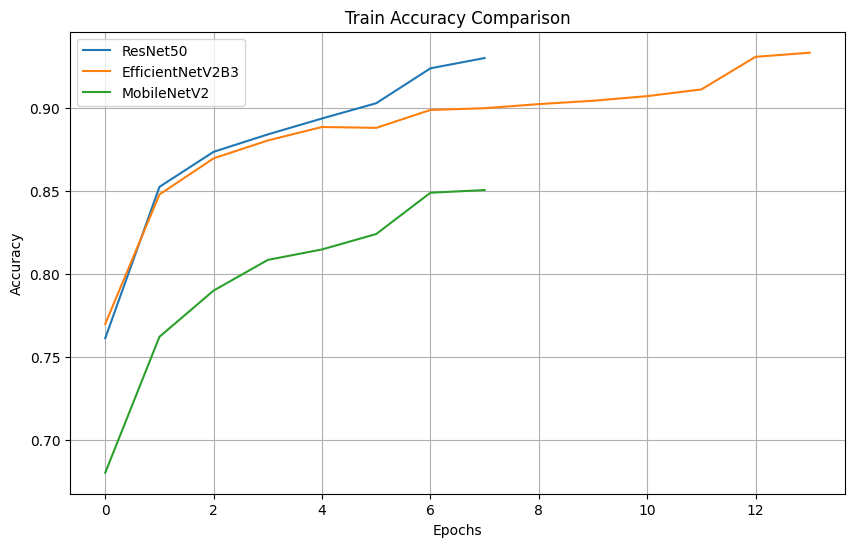

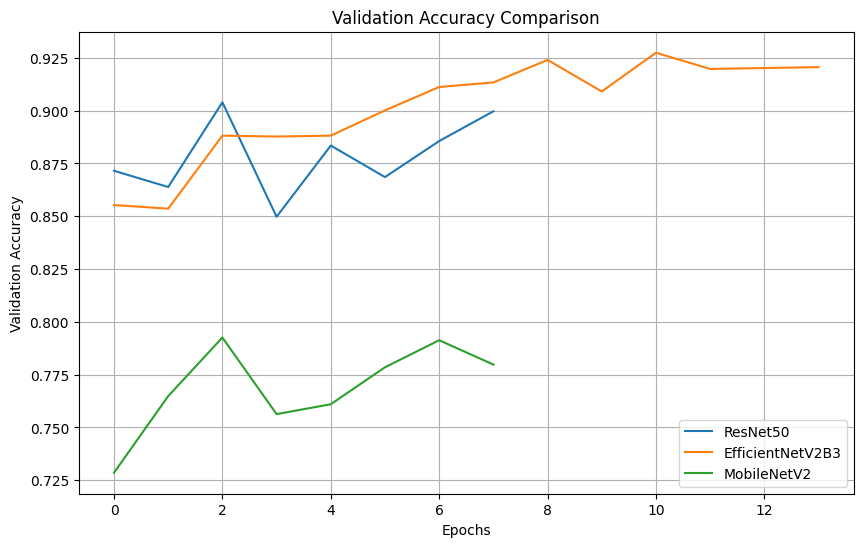

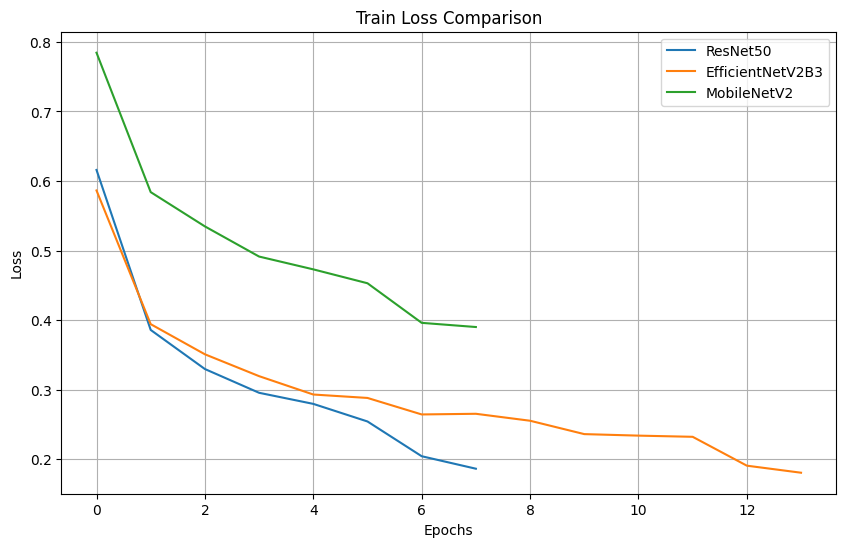

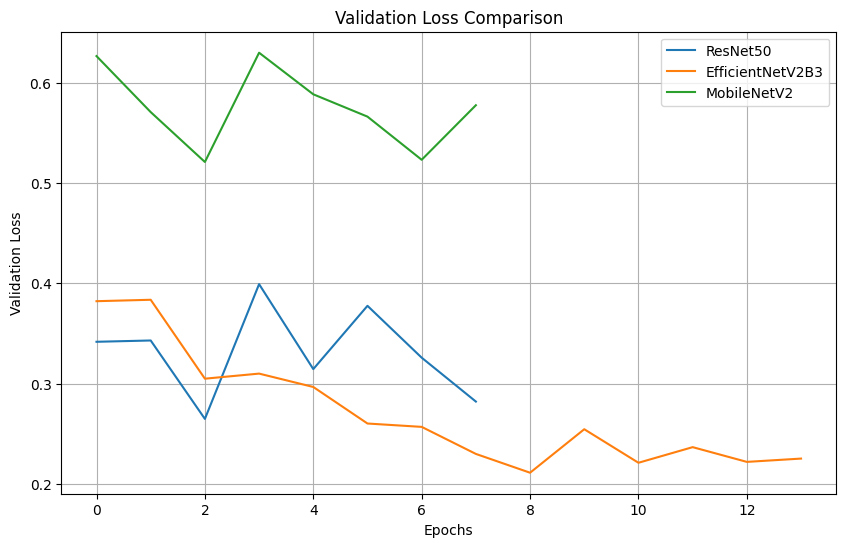

In [34]:
def plot_metric(histories, metric, title, ylabel):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    for name, h in histories.items():
        plt.plot(h['history'].history[metric], label=name)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


# Accuracy grafikleri
plot_metric(histories, 'accuracy', 'Train Accuracy Comparison', 'Accuracy')
plot_metric(histories, 'val_accuracy', 'Validation Accuracy Comparison', 'Validation Accuracy')

# Loss grafikleri
plot_metric(histories, 'loss', 'Train Loss Comparison', 'Loss')
plot_metric(histories, 'val_loss', 'Validation Loss Comparison', 'Validation Loss')


In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3


import tensorflow as tf
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

@tf.keras.utils.register_keras_serializable()
class SpatialAttentionPooling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        return tf.concat([avg_pool, max_pool], axis=-1)

    def get_config(self):
        return super().get_config()



def cbam_block(x, ratio=8):

    channel = x.shape[-1]

    # ----- Channel Attention -----
    avg_pool_ch = layers.GlobalAveragePooling2D()(x)
    max_pool_ch = layers.GlobalMaxPooling2D()(x)
    avg_pool_ch = layers.Dense(channel // ratio, activation='relu')(avg_pool_ch)
    avg_pool_ch = layers.Dense(channel)(avg_pool_ch)
    max_pool_ch = layers.Dense(channel // ratio, activation='relu')(max_pool_ch)
    max_pool_ch = layers.Dense(channel)(max_pool_ch)
    channel_attention = layers.Activation('sigmoid')(layers.Add()([avg_pool_ch, max_pool_ch]))
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    x_ch_att = layers.Multiply()([x, channel_attention])

    # ----- Spatial Attention-----
    concat_spatial = SpatialAttentionPooling()(x_ch_att)
    spatial_attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat_spatial)
    x_sp_att = layers.Multiply()([x_ch_att, spatial_attention])

    return x_sp_att


def build_efficientnet_cbam(input_shape=(224, 224, 3), num_classes=4):

    base = EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base.trainable = True

    x = base.output
    x = cbam_block(x, ratio=8)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base.input, outputs=outputs)
    return model



model = build_efficientnet_cbam(input_shape=(224,224,3), num_classes=num_classes)

#loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import time

checkpoint = ModelCheckpoint("EfficientNet_CBAM_best.keras", monitor='val_accuracy', mode='max',save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
csv_logger = CSVLogger("EfficientNet_CBAM_training_log.csv", append=True)

class CarbonLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    def on_train_end(self, logs=None):
        duration = time.time() - self.start_time
        print(f"\nTraining finished in {duration/60:.2f} minutes.")
        print("Approx. Carbon emission: {:.4f} kgCO2e".format(duration*0.0002))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger, CarbonLogger()]


EPOCHS = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40


E0000 00:00:1758054301.468407     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054301.617821     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054302.611142     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054302.758160     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 15/293 ━━━━━━━━━━━━━━━━━━━━ 2:00 434ms/step - accuracy: 0.5427 - loss: 1.1380

E0000 00:00:1758054364.725992     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054364.873599     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054365.431326     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758054365.578417     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8465 - loss: 0.4353
Epoch 1: val_accuracy improved from -inf to 0.83568, saving model to EfficientNet_CBAM_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 359s 722ms/step - accuracy: 0.8467 - loss: 0.4348 - val_accuracy: 0.8357 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 2/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9592 - loss: 0.1239
Epoch 2: val_accuracy improved from 0.83568 to 0.88220, saving model to EfficientNet_CBAM_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 138s 468ms/step - accuracy: 0.9593 - loss: 0.1238 - val_accuracy: 0.8822 - val_loss: 4.6399 - learning_rate: 0.0010
Epoch 3/40
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9740 - loss: 0.0769
Epoch 3: val_accuracy improved from 0.88220 to 0.91293, saving model to EfficientNet_CBAM_best.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 138s 471ms/step - accuracy: 0.9740 - loss: 0.0769 - val_accuracy: 0.9129 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 4/40
2

In [46]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory

MODEL_PATH = '/kaggle/working/EfficientNet_CBAM_best.keras'

TEST_DATA_DIR = '/kaggle/input/brain-tumor-dataset/Testing' 


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

@tf.keras.utils.register_keras_serializable()
class SpatialAttentionPooling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        return tf.concat([avg_pool, max_pool], axis=-1)
    def get_config(self):
        return super().get_config()

print(f"Loading model from: {MODEL_PATH}")
try:
    model = load_model(MODEL_PATH)
    print(" Model loaded successfully.")
except Exception as e:
    print(f" Error loading model: {e}")
    model = None

if model:
    print(f"Loading test dataset from: {TEST_DATA_DIR}")
    try:
        results = model.evaluate(test_ds, return_dict=True)
        
        print("\n--- Final Test Results ---")
        print(f"Test Loss: {results['loss']:.4f}")
        print(f"Test Accuracy: {results['accuracy'] * 100:.2f}%")

    except FileNotFoundError:
        print(f" Error: Test directory not found at {TEST_DATA_DIR}")

Loading model from: /kaggle/working/EfficientNet_CBAM_best.keras
 Model loaded successfully.
Loading test dataset from: /kaggle/input/brain-tumor-dataset/Testing
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.9909 - loss: 0.0497

--- Final Test Results ---
Test Loss: 0.0321
Test Accuracy: 99.47%


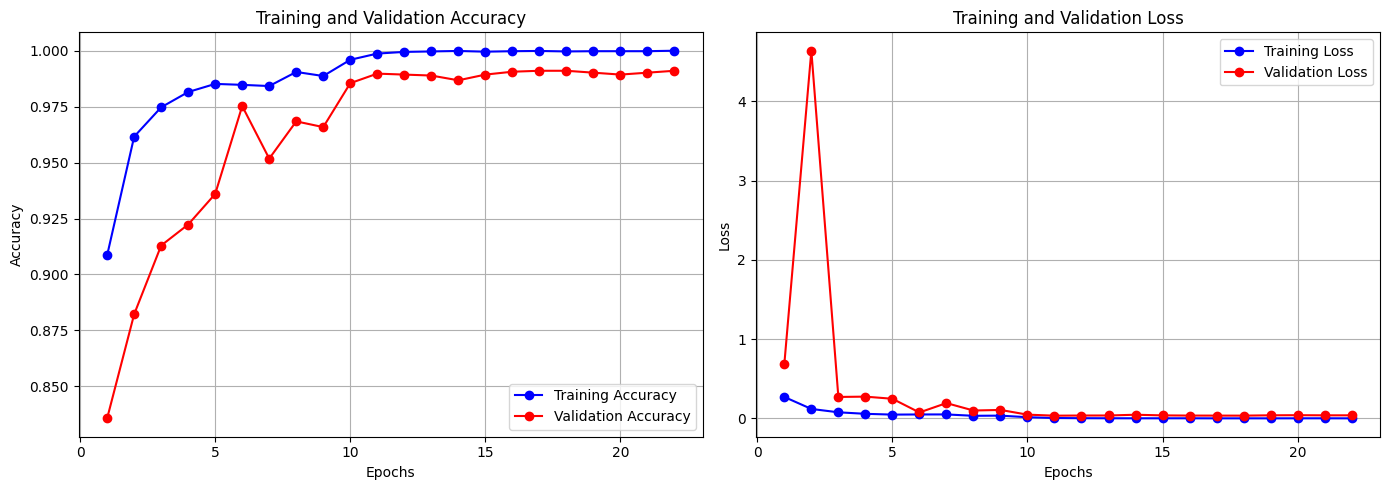

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
              precision    recall  f1-score   support

      giloma       1.00      0.98      0.99       300
  meningioma       0.99      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



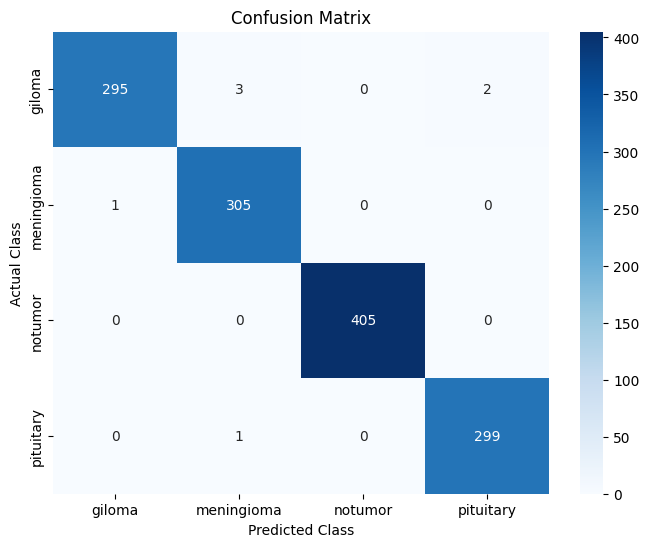

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




y_true = np.concatenate([labels for images, labels in test_ds], axis=0)

    
predictions = model.predict(test_ds)
    
y_pred = np.argmax(predictions, axis=1)
    
print(classification_report(y_true, y_pred, target_names=class_names))



class_names = ['giloma', 'meningioma', 'notumor', 'pituitary'] 

# print("\n--- Classification Report ---")
# print(classification_report(y_true, y_pred, target_names=class_names))




cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.savefig("latest_model_confusion_matrix.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()
# plt.savefig("confusion_matrix_efficientnet_cbam.svg", format='svg', dpi=300, bbox_inches='tight')

In [57]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import cv2
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Could not find a Conv2D layer in the model.")

def generate_hires_cam_heatmap(img_array, model, last_conv_layer_name, target_class_index):

    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if target_class_index is None:
            target_class_index = tf.argmax(preds[0])
        class_channel = preds[:, target_class_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    element_wise_product = grads[0] * last_conv_layer_output[0]
    
    
    heatmap = tf.reduce_sum(element_wise_product, axis=-1)
    

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy(), preds.numpy()

def superimpose_gradcam(original_img, heatmap, alpha=0.5):
    img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR) 
    heatmap = cv2.resize(heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img_bgr
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return superimposed_img_rgb


In [79]:
def plot_grad_cam_on_images(model, image_paths, target_class_index, class_names):

    num_images = len(image_paths)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 8.5))
    
    target_class_name = class_names[target_class_index]
    fig.suptitle(f"HiResCAM focus for TARGET class: '{target_class_name}'", fontsize=16)

    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path, target_size=(224, 224))
        original_img = image.img_to_array(img).astype('uint8')
        img_array = np.expand_dims(original_img, axis=0)

        last_conv_layer = find_last_conv_layer(model)
        heatmap, preds = generate_hires_cam_heatmap(img_array, model, last_conv_layer, target_class_index)
        superimposed_img = superimpose_gradcam(original_img, heatmap)

        predicted_class_index = np.argmax(preds[0])
        predicted_class_name = class_names[predicted_class_index]
        confidence_score = np.max(preds[0]) * 100
        
        ax_orig = axes[0, i] if num_images > 1 else axes[0]
        ax_orig.imshow(original_img)
        ax_orig.set_title(f'Original Image {i+1}')
        ax_orig.axis('off')

        ax_cam = axes[1, i] if num_images > 1 else axes[1]
        ax_cam.imshow(superimposed_img)
        ax_cam.set_title(f'Predicted: {predicted_class_name}\nConfidence: {confidence_score:.2f}%')
        ax_cam.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    plt.show()



Randomly selected 5 images for visualization.
Loading model from: EfficientNet_CBAM_best.keras


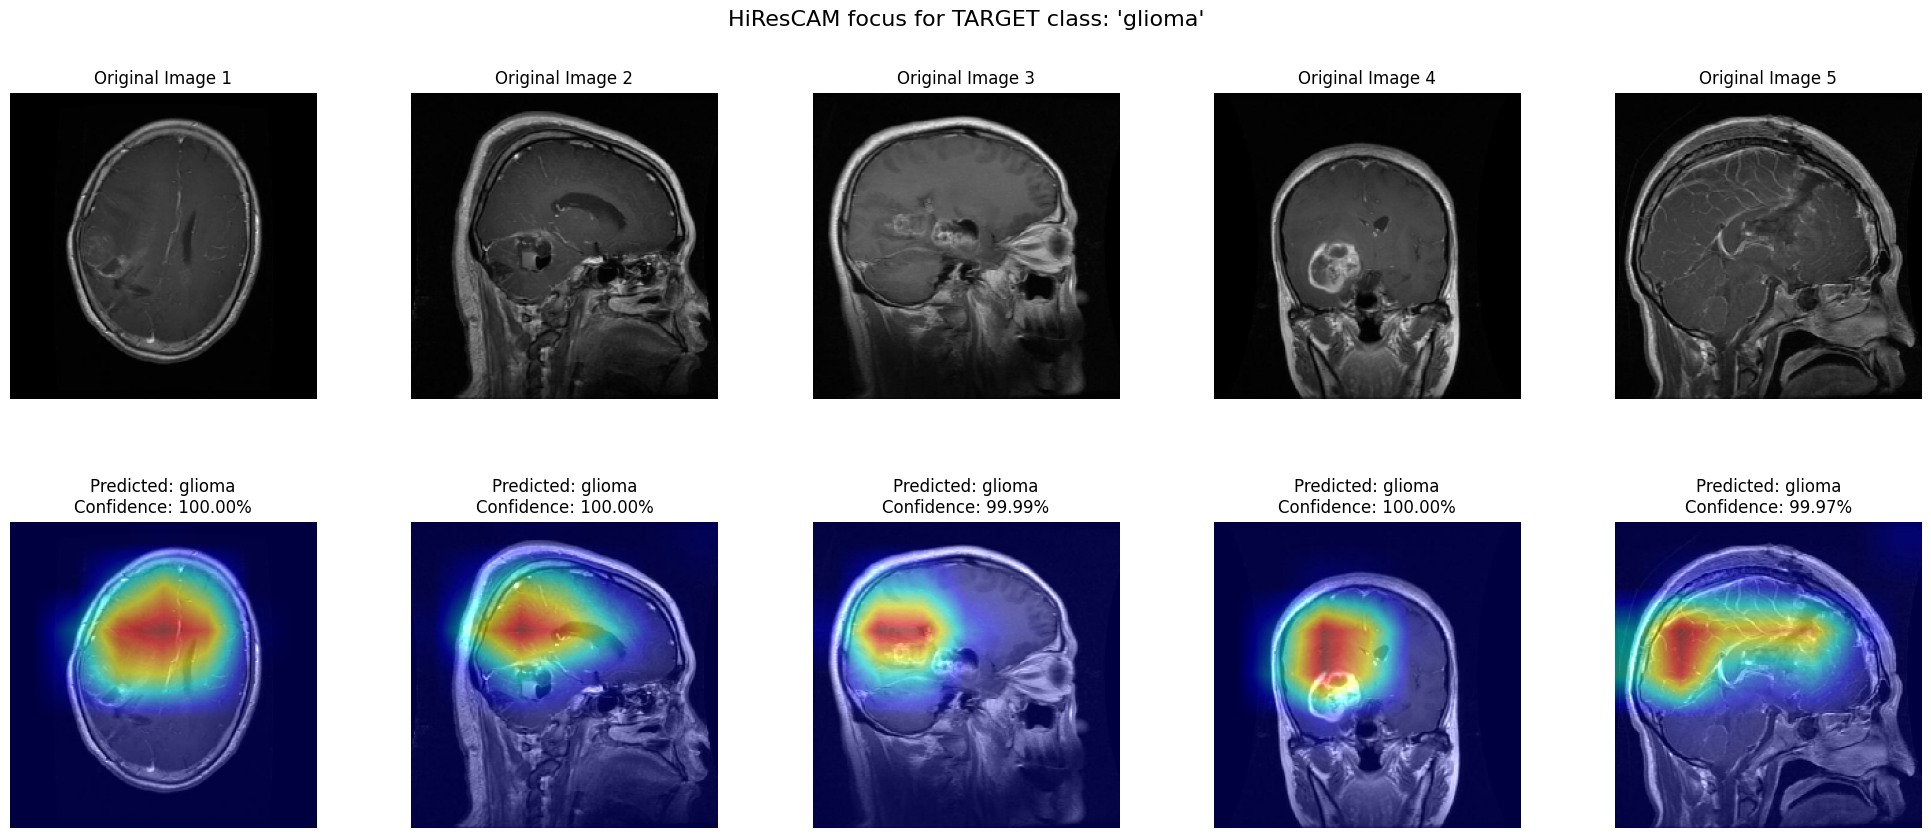

In [86]:
import os
import random 

BEST_MODEL_PATH = "EfficientNet_CBAM_best.keras"


CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary'] 


TARGET_CLASS_NAME = 'glioma'


TUMORS_PATH = '/kaggle/input/brain-tumor-dataset/Testing/glioma'
try:
    
    all_images = [os.path.join(TUMORS_PATH, filename) for filename in os.listdir(TUMORS_PATH)]
    
    
    num_to_sample = min(5, len(all_images))
    
    IMAGE_PATHS = random.sample(all_images, num_to_sample)
    
    print(f"Randomly selected {len(IMAGE_PATHS)} images for visualization.")

except FileNotFoundError:
    print(f"Error: Directory not found at {TUMORS_PATH}. Please update the path.")
    IMAGE_PATHS = []


if os.path.exists(BEST_MODEL_PATH) and IMAGE_PATHS:
    print(f"Loading model from: {BEST_MODEL_PATH}")

    best_model = tf.keras.models.load_model(BEST_MODEL_PATH)

    
    try:
        target_index = CLASS_NAMES.index(TARGET_CLASS_NAME)
        
        
        plot_grad_cam_on_images(
            model=best_model, 
            image_paths=IMAGE_PATHS, 
            target_class_index=target_index,
            class_names=CLASS_NAMES
        )
    except ValueError:
        print(f"Error: Target class '{TARGET_CLASS_NAME}' not found in CLASS_NAMES list.")
else:
    if not os.path.exists(BEST_MODEL_PATH):
        print(f"Error: Model file not found at '{BEST_MODEL_PATH}'. Please check the path.")
    if not IMAGE_PATHS:
        print("Error: No image paths found. Please check the TUMORS_PATH directory.")

In [67]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(10, 11.5)):
    plt.figure(figsize=figsize)
    
    num_rows = int(np.ceil(np.sqrt(num_samples)))
    num_cols = int(np.ceil(num_samples / num_rows))
    
    images_to_plot = []
    labels_to_plot = []

    for batch_images, batch_labels in dataset.take(num_samples // BATCH_SIZE + 1):
        for img, lbl in zip(batch_images, batch_labels):
            if len(images_to_plot) < num_samples:
                images_to_plot.append(img)
                labels_to_plot.append(lbl)
            else:
                break
        if len(images_to_plot) >= num_samples:
            break
            
    for i in range(num_samples):
        if i >= len(images_to_plot):
            break

        image_tensor = images_to_plot[i]
        true_label_int = labels_to_plot[i].numpy()
        
        image_batch = tf.expand_dims(image_tensor, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label_int = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions[0]) * 100

        true_class = index_to_class[true_label_int]
        predicted_class = index_to_class[predicted_label_int]

        title_color = 'green' if true_label_int == predicted_label_int else 'red'

        plt.subplot(num_rows, num_cols, i + 1)
        

        plt.imshow(image_tensor.numpy().astype("uint8"))
        
        plt.title(f"True: {true_class}\nPred: {predicted_class} ({confidence:.2f}%)", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



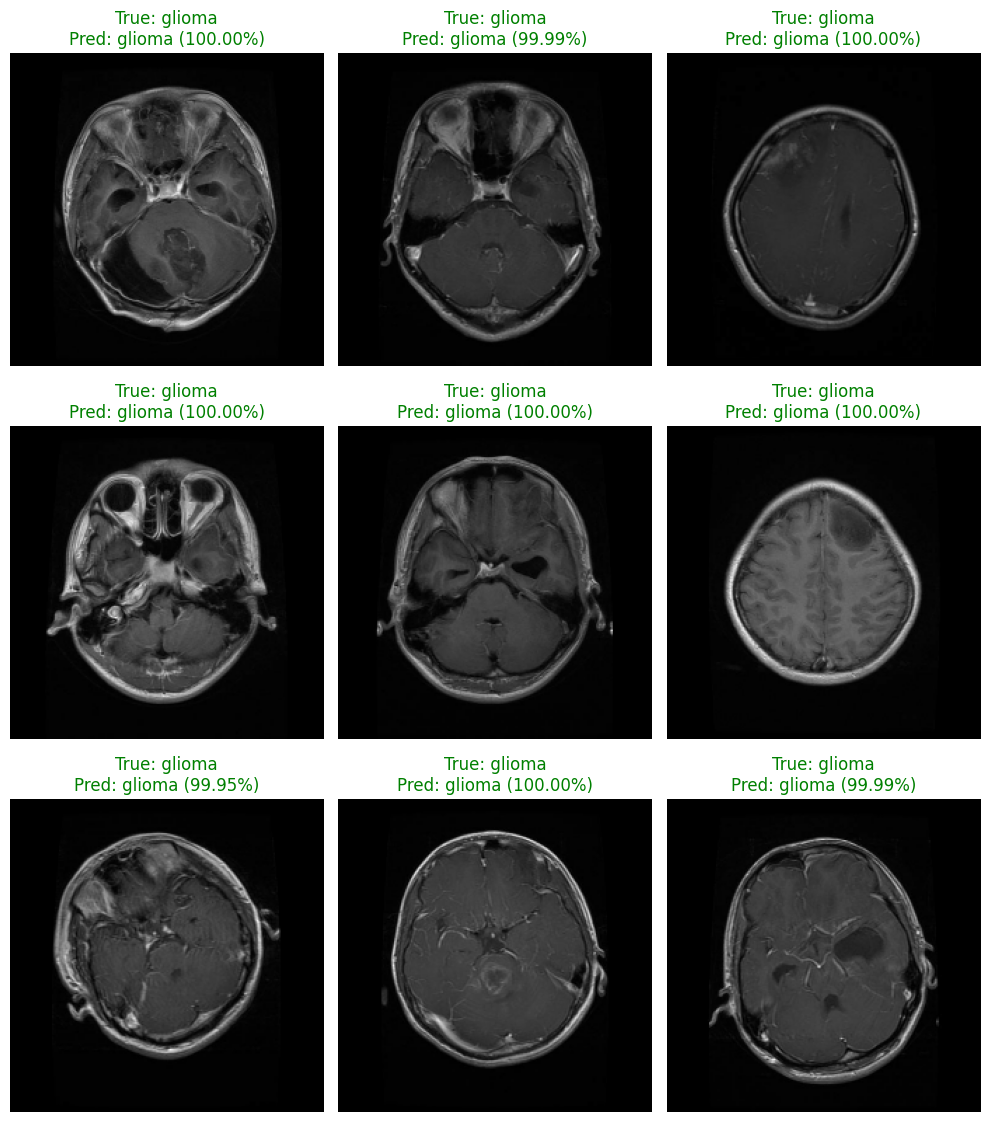

In [68]:

class_names = train_val_ds.class_names


inv_class_mappings = {i: name for i, name in enumerate(class_names)}


plot_sample_predictions(
    model=model,
    dataset=test_ds, 
    index_to_class=inv_class_mappings, 
    num_samples=9,
    figsize=(10, 11.5)
)
